In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter("ignore", category=DeprecationWarning) 
warnings.simplefilter("ignore", UserWarning)

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

njobs = -1

In [2]:
train=pd.read_csv('../../1. Task and Data/train.csv',sep='|')

In [3]:
print(train.fraud.value_counts())
print(train.fraud.value_counts() / len(train))

0    1775
1     104
Name: fraud, dtype: int64
0    0.944651
1    0.055349
Name: fraud, dtype: float64


# Feature Engineering

In [4]:
train['scannedLineItems'] = train['scannedLineItemsPerSecond'] * train['totalScanTimeInSeconds']
train['pricePerScannedLineItem'] = train['grandTotal'] / train['scannedLineItems']
train['scansWithoutRegistrationPerScannedLineItem'] = train['scansWithoutRegistration'] / train['scannedLineItems']
train['quantityModificationsPerScannedLineItem'] = train['quantityModifications'] / train['scannedLineItems']
train['lineItemVoidsPerSecond'] = train['lineItemVoids'] / train['totalScanTimeInSeconds']
train['scansWithoutRegistrationPerSecond'] = train['scansWithoutRegistration'] / train['totalScanTimeInSeconds']
train['quantityModificationsPerSecond'] = train['quantityModifications'] / train['totalScanTimeInSeconds']
train['secondsPerEuro'] = train['totalScanTimeInSeconds'] / train['grandTotal']
train['lineItemVoidsPerEuro'] = train['lineItemVoids'] / train['grandTotal']
train['scansWithoutRegistrationPerEuro'] = train['scansWithoutRegistration'] / train['grandTotal']
train['quantityModificationsPerEuro'] = train['quantityModifications'] / train['grandTotal']

train.to_csv("Train Set - New Features.csv")

In [5]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import make_scorer


def my_custom_loss_func(y_true, y_pred):
    cm = confusion_matrix(y_true,y_pred)
    tn, fp, fn, tp = cm.ravel()
    score = ((-25)*fp + (-5)*fn + 5*tp) / len(y_true)
    return (score)

my_custom_score = make_scorer(my_custom_loss_func, greater_is_better=True)

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import LeaveOneOut

skf = StratifiedKFold(n_splits=10)

# Model factory

In [6]:
from sklearn.tree import ExtraTreeClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV


model_tuning_factory = [
    GridSearchCV(ExtraTreeClassifier(),
                 dict(criterion = ['entropy', 'gini'],
                      splitter = ['best', 'random'],
                      min_samples_split = range(2,10),
                      max_depth = range(1,50)),
                 cv = skf,
                 scoring = my_custom_score)
]           
                 
                 
iterations = 100                 
               
model_tuning_factory_randomized = [
    RandomizedSearchCV(ExtraTreeClassifier(),
                 dict(criterion = ['entropy', 'gini'],
                      splitter = ['best', 'random'],
                      min_samples_split = range(2,10),
                      max_depth = range(1,50)),
                 cv = skf,
                 scoring = my_custom_score,
                      n_iter  = iterations)
]

In [7]:
Y = train['fraud']
X = train.drop('fraud',axis=1)

In [8]:
import time
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif

from sklearn.feature_selection import RFECV
from sklearn.feature_selection import RFE

from sklearn.preprocessing import MinMaxScaler 
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer

result_table = pd.DataFrame(columns=["Model", "Data Preparation", "Feature Count", "Features", "Optimal Parameters", "Monetary Value Per Instance - Mean", "Monetary Value Per Instance - Standard Deviation", "Raw Model"])


# Scaling is not relevant for Decision Trees
for data_preparation_strategy in range(1,2):
    if (data_preparation_strategy == 1):  
        X_scaled = X
        data_preparation = "No Scaling"
    elif (data_preparation_strategy == 2):
        feature_scaler = MinMaxScaler()  
        X_scaled = pd.DataFrame(feature_scaler.fit_transform(X.values), columns=X.columns, index=X.index) 
        data_preparation = "MinMaxScaler"
    elif (data_preparation_strategy == 3):
        feature_scaler = StandardScaler()  
        X_scaled = pd.DataFrame(feature_scaler.fit_transform(X.values), columns=X.columns, index=X.index)
        data_preparation = "StandardScaler"
    elif (data_preparation_strategy == 4):
        transformer = FunctionTransformer(np.log1p, validate=True)  
        X_scaled = pd.DataFrame(transformer.transform(X), columns=X.columns, index=X.index)
        data_preparation = "LogScaler"    

    for model in model_tuning_factory:   # replace with model_tuning_factory_randomized for faster results


        for feature_count in range(1,len(list(X))+1):

            model.seed = 42
            start_time = time.time()              


            # Solution with SelectKBest
            best_features = SelectKBest(f_classif, k=feature_count).fit(X_scaled,Y)
            best_feature_list = X.columns[best_features.get_support()]
            X_selected_features = X[best_feature_list]

            model.fit(X_selected_features,Y)  
            model_name = model.best_estimator_.__class__.__name__
            score_mean = model.cv_results_['mean_test_score'][model.best_index_]
            score_std = model.cv_results_['std_test_score'][model.best_index_]

            result_table = result_table.append({
             "Model": model_name, 
             "Data Preparation": data_preparation,   
             "Feature Count": feature_count,
             "Feature Selection Technique": "SelectKBest",   
             "Features": best_feature_list.values, 
             "Optimal Parameters": model.best_params_,
             "Monetary Value Per Instance - Mean":  score_mean,
             "Monetary Value Per Instance - Standard Deviation": score_std,   
             "Raw Model": model.best_estimator_
              }, ignore_index=True)


            # Solution with Recursive Feature Elimination -> only works for some models

            if (model.estimator.__class__.__name__ == 'LogisticRegression'
             or model.estimator.__class__.__name__ == 'DecisionTreeClassifier'
             or model.estimator.__class__.__name__ == 'ExtraTreeClassifier'
             or model.estimator.__class__.__name__ == 'ExtraTreesClassifier'
             or model.estimator.__class__.__name__ == 'RandomForestClassifier'
             or model.estimator.__class__.__name__ == 'BernoulliNB'
             or model.estimator.__class__.__name__ == 'AdaBoostClassifier'
             or model.estimator.__class__.__name__ == 'GradientBoostingClassifier'
             or model.estimator.__class__.__name__ == 'Perceptron'
             or model.estimator.__class__.__name__ == 'LinearDiscriminantAnalysis'):

               # Traditional RFE
                rfe = RFE(model.estimator, n_features_to_select = feature_count)
                rfe = rfe.fit(X,Y)
                best_feature_list = np.array(list(X))[np.array(rfe.support_)]
                X_selected_features = X[best_feature_list]

                model.fit(X_selected_features,Y)  
                model_name = model.best_estimator_.__class__.__name__
                score_mean = model.cv_results_['mean_test_score'][model.best_index_]
                score_std = model.cv_results_['std_test_score'][model.best_index_]


                result_table = result_table.append({
                 "Model": model_name, 
                 "Data Preparation": data_preparation,
                 "Feature Count": feature_count,
                 "Feature Selection Technique": "RFE",
                 "Features": best_feature_list,
                 "Optimal Parameters": model.best_params_,
                 "Monetary Value Per Instance - Mean":  score_mean,
                 "Monetary Value Per Instance - Standard Deviation": score_std,  
                 "Raw Model": model.best_estimator_
                  }, ignore_index=True)

            end_time = time.time()

            print("Finished " + model.best_estimator_.__class__.__name__ + " with " + data_preparation + " and " + str(feature_count) + " features after " + str(round(end_time - start_time, 2)) + " seconds")



        if (model.estimator.__class__.__name__ == 'LogisticRegression'
         or model.estimator.__class__.__name__ == 'DecisionTreeClassifier'
         or model.estimator.__class__.__name__ == 'ExtraTreeClassifier'
         or model.estimator.__class__.__name__ == 'ExtraTreesClassifier'
         or model.estimator.__class__.__name__ == 'RandomForestClassifier'
         or model.estimator.__class__.__name__ == 'BernoulliNB'
         or model.estimator.__class__.__name__ == 'AdaBoostClassifier'
         or model.estimator.__class__.__name__ == 'GradientBoostingClassifier'
         or model.estimator.__class__.__name__ == 'Perceptron'
         or model.estimator.__class__.__name__ == 'LinearDiscriminantAnalysis'):

            # RFE with Cross Validation -> determines the optimum feature count automatically
            rfecv = RFECV(model.estimator, cv = skf, scoring = my_custom_score)
            rfecv = rfe.fit(X,Y)
            best_feature_list = np.array(list(X))[np.array(rfecv.support_)]
            X_selected_features = X[best_feature_list]

            model.fit(X_selected_features,Y)  
            model_name = model.best_estimator_.__class__.__name__
            score_mean = model.cv_results_['mean_test_score'][model.best_index_]
            score_std = model.cv_results_['std_test_score'][model.best_index_]


            result_table = result_table.append({
             "Model": model_name,  
             "Data Preparation": data_preparation,
             "Feature Count": len(best_feature_list),
             "Feature Selection Technique": "RFECV",
             "Features": best_feature_list,
             "Optimal Parameters": model.best_params_,
             "Monetary Value Per Instance - Mean":  score_mean,
             "Monetary Value Per Instance - Standard Deviation": score_std,    
             "Raw Model": model.best_estimator_
              }, ignore_index=True)

result_table.sort_values(by = "Monetary Value Per Instance - Mean", ascending = False)

C:\Users\ahuem\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Finished ExtraTreeClassifier with No Scaling and 1 features after 118.85 seconds


C:\Users\ahuem\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\ahuem\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Finished ExtraTreeClassifier with No Scaling and 2 features after 118.65 seconds


C:\Users\ahuem\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\ahuem\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Finished ExtraTreeClassifier with No Scaling and 3 features after 164.2 seconds


C:\Users\ahuem\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\ahuem\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Finished ExtraTreeClassifier with No Scaling and 4 features after 143.05 seconds


C:\Users\ahuem\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\ahuem\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Finished ExtraTreeClassifier with No Scaling and 5 features after 123.91 seconds


C:\Users\ahuem\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\ahuem\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Finished ExtraTreeClassifier with No Scaling and 6 features after 128.06 seconds


C:\Users\ahuem\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\ahuem\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Finished ExtraTreeClassifier with No Scaling and 7 features after 180.74 seconds


C:\Users\ahuem\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\ahuem\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Finished ExtraTreeClassifier with No Scaling and 8 features after 150.92 seconds


C:\Users\ahuem\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\ahuem\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Finished ExtraTreeClassifier with No Scaling and 9 features after 205.06 seconds


C:\Users\ahuem\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\ahuem\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Finished ExtraTreeClassifier with No Scaling and 10 features after 199.79 seconds


C:\Users\ahuem\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\ahuem\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Finished ExtraTreeClassifier with No Scaling and 11 features after 174.27 seconds


C:\Users\ahuem\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\ahuem\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Finished ExtraTreeClassifier with No Scaling and 12 features after 211.12 seconds


C:\Users\ahuem\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\ahuem\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Finished ExtraTreeClassifier with No Scaling and 13 features after 223.47 seconds


C:\Users\ahuem\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\ahuem\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Finished ExtraTreeClassifier with No Scaling and 14 features after 239.63 seconds


C:\Users\ahuem\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\ahuem\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Finished ExtraTreeClassifier with No Scaling and 15 features after 236.75 seconds


C:\Users\ahuem\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\ahuem\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Finished ExtraTreeClassifier with No Scaling and 16 features after 248.77 seconds


C:\Users\ahuem\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\ahuem\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Finished ExtraTreeClassifier with No Scaling and 17 features after 237.58 seconds


C:\Users\ahuem\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\ahuem\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Finished ExtraTreeClassifier with No Scaling and 18 features after 229.79 seconds


C:\Users\ahuem\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\ahuem\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Finished ExtraTreeClassifier with No Scaling and 19 features after 229.16 seconds


C:\Users\ahuem\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\ahuem\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Finished ExtraTreeClassifier with No Scaling and 20 features after 231.31 seconds


C:\Users\ahuem\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


,Model,Data Preparation,Feature Count,Features,Optimal Parameters,Monetary Value Per Instance - Mean,Monetary Value Per Instance - Standard Deviation,Raw Model,Feature Selection Technique
7,ExtraTreeClassifier,No Scaling,4,"[trustLevel, totalScanTimeInSeconds, scansWith...","{'criterion': 'gini', 'max_depth': 45, 'min_sa...",0.037254,0.147497,"ExtraTreeClassifier(class_weight=None, criteri...",RFE
19,ExtraTreeClassifier,No Scaling,10,"[trustLevel, totalScanTimeInSeconds, lineItemV...","{'criterion': 'gini', 'max_depth': 22, 'min_sa...",0.013305,0.205118,"ExtraTreeClassifier(class_weight=None, criteri...",RFE
9,ExtraTreeClassifier,No Scaling,5,"[trustLevel, totalScanTimeInSeconds, scansWith...","{'criterion': 'entropy', 'max_depth': 41, 'min...",0.010644,0.142409,"ExtraTreeClassifier(class_weight=None, criteri...",RFE
11,ExtraTreeClassifier,No Scaling,6,"[trustLevel, totalScanTimeInSeconds, lineItemV...","{'criterion': 'entropy', 'max_depth': 15, 'min...",-0.005322,0.141551,"ExtraTreeClassifier(class_weight=None, criteri...",RFE
21,ExtraTreeClassifier,No Scaling,11,"[trustLevel, totalScanTimeInSeconds, grandTota...","{'criterion': 'gini', 'max_depth': 36, 'min_sa...",-0.010644,0.174467,"ExtraTreeClassifier(class_weight=None, criteri...",RFE
17,ExtraTreeClassifier,No Scaling,9,"[trustLevel, totalScanTimeInSeconds, scannedLi...","{'criterion': 'entropy', 'max_depth': 37, 'min...",-0.013305,0.247023,"ExtraTreeClassifier(class_weight=None, criteri...",RFE
14,ExtraTreeClassifier,No Scaling,8,"[trustLevel, totalScanTimeInSeconds, scansWith...","{'criterion': 'entropy', 'max_depth': 26, 'min...",-0.015966,0.124229,"ExtraTreeClassifier(class_weight=None, criteri...",SelectKBest
22,ExtraTreeClassifier,No Scaling,12,"[trustLevel, totalScanTimeInSeconds, lineItemV...","{'criterion': 'entropy', 'max_depth': 14, 'min...",-0.023949,0.199321,"ExtraTreeClassifier(class_weight=None, criteri...",SelectKBest
18,ExtraTreeClassifier,No Scaling,10,"[trustLevel, totalScanTimeInSeconds, lineItemV...","{'criterion': 'gini', 'max_depth': 19, 'min_sa...",-0.023949,0.078370,"ExtraTreeClassifier(class_weight=None, criteri...",SelectKBest
4,ExtraTreeClassifier,No Scaling,3,"[trustLevel, totalScanTimeInSeconds, scannedLi...","{'criterion': 'entropy', 'max_depth': 40, 'min...",-0.031932,0.150353,"ExtraTreeClassifier(class_weight=None, criteri...",SelectKBest


In [9]:
result_table.sort_values(by = "Monetary Value Per Instance - Mean", ascending = False)

,Model,Data Preparation,Feature Count,Features,Optimal Parameters,Monetary Value Per Instance - Mean,Monetary Value Per Instance - Standard Deviation,Raw Model,Feature Selection Technique
7,ExtraTreeClassifier,No Scaling,4,"[trustLevel, totalScanTimeInSeconds, scansWith...","{'criterion': 'gini', 'max_depth': 45, 'min_sa...",0.037254,0.147497,"ExtraTreeClassifier(class_weight=None, criteri...",RFE
19,ExtraTreeClassifier,No Scaling,10,"[trustLevel, totalScanTimeInSeconds, lineItemV...","{'criterion': 'gini', 'max_depth': 22, 'min_sa...",0.013305,0.205118,"ExtraTreeClassifier(class_weight=None, criteri...",RFE
9,ExtraTreeClassifier,No Scaling,5,"[trustLevel, totalScanTimeInSeconds, scansWith...","{'criterion': 'entropy', 'max_depth': 41, 'min...",0.010644,0.142409,"ExtraTreeClassifier(class_weight=None, criteri...",RFE
11,ExtraTreeClassifier,No Scaling,6,"[trustLevel, totalScanTimeInSeconds, lineItemV...","{'criterion': 'entropy', 'max_depth': 15, 'min...",-0.005322,0.141551,"ExtraTreeClassifier(class_weight=None, criteri...",RFE
21,ExtraTreeClassifier,No Scaling,11,"[trustLevel, totalScanTimeInSeconds, grandTota...","{'criterion': 'gini', 'max_depth': 36, 'min_sa...",-0.010644,0.174467,"ExtraTreeClassifier(class_weight=None, criteri...",RFE
17,ExtraTreeClassifier,No Scaling,9,"[trustLevel, totalScanTimeInSeconds, scannedLi...","{'criterion': 'entropy', 'max_depth': 37, 'min...",-0.013305,0.247023,"ExtraTreeClassifier(class_weight=None, criteri...",RFE
14,ExtraTreeClassifier,No Scaling,8,"[trustLevel, totalScanTimeInSeconds, scansWith...","{'criterion': 'entropy', 'max_depth': 26, 'min...",-0.015966,0.124229,"ExtraTreeClassifier(class_weight=None, criteri...",SelectKBest
22,ExtraTreeClassifier,No Scaling,12,"[trustLevel, totalScanTimeInSeconds, lineItemV...","{'criterion': 'entropy', 'max_depth': 14, 'min...",-0.023949,0.199321,"ExtraTreeClassifier(class_weight=None, criteri...",SelectKBest
18,ExtraTreeClassifier,No Scaling,10,"[trustLevel, totalScanTimeInSeconds, lineItemV...","{'criterion': 'gini', 'max_depth': 19, 'min_sa...",-0.023949,0.078370,"ExtraTreeClassifier(class_weight=None, criteri...",SelectKBest
4,ExtraTreeClassifier,No Scaling,3,"[trustLevel, totalScanTimeInSeconds, scannedLi...","{'criterion': 'entropy', 'max_depth': 40, 'min...",-0.031932,0.150353,"ExtraTreeClassifier(class_weight=None, criteri...",SelectKBest


In [22]:
#result_table.to_pickle("result_table_Extra_Tree.pkl")
result_table = pd.read_pickle("result_table_Extra_Tree.pkl")

Text(0, 0.5, 'Monetary Value Per Instance - Mean')

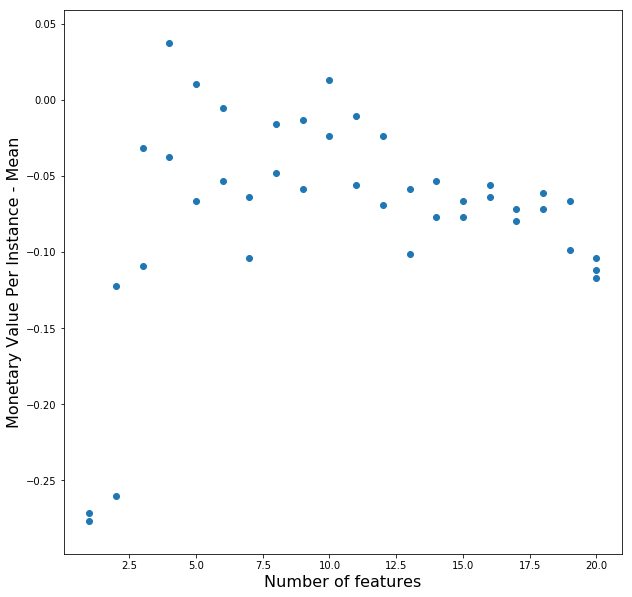

In [11]:
plt.rcParams['figure.figsize'] = (10,10)

plt.scatter(result_table["Feature Count"], result_table["Monetary Value Per Instance - Mean"])
plt.xlabel('Number of features', fontsize=16)
plt.ylabel('Monetary Value Per Instance - Mean', fontsize=16)

In [14]:
best_model = result_table.loc[result_table["Monetary Value Per Instance - Mean"].argmax()]["Raw Model"]
best_model_features = result_table.loc[result_table["Monetary Value Per Instance - Mean"].argmax()]["Features"]
best_parameters = result_table.loc[result_table["Monetary Value Per Instance - Mean"].argmax()]["Optimal Parameters"]

print(best_model)
print(best_model_features)
print(best_parameters)

ExtraTreeClassifier(class_weight=None, criterion='gini', max_depth=45,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_decrease=0.0, min_impurity_split=None,
          min_samples_leaf=1, min_samples_split=9,
          min_weight_fraction_leaf=0.0, random_state=None, splitter='best')
['trustLevel' 'totalScanTimeInSeconds' 'scansWithoutRegistration'
 'scannedLineItems']
{'criterion': 'gini', 'max_depth': 45, 'min_samples_split': 9, 'splitter': 'best'}


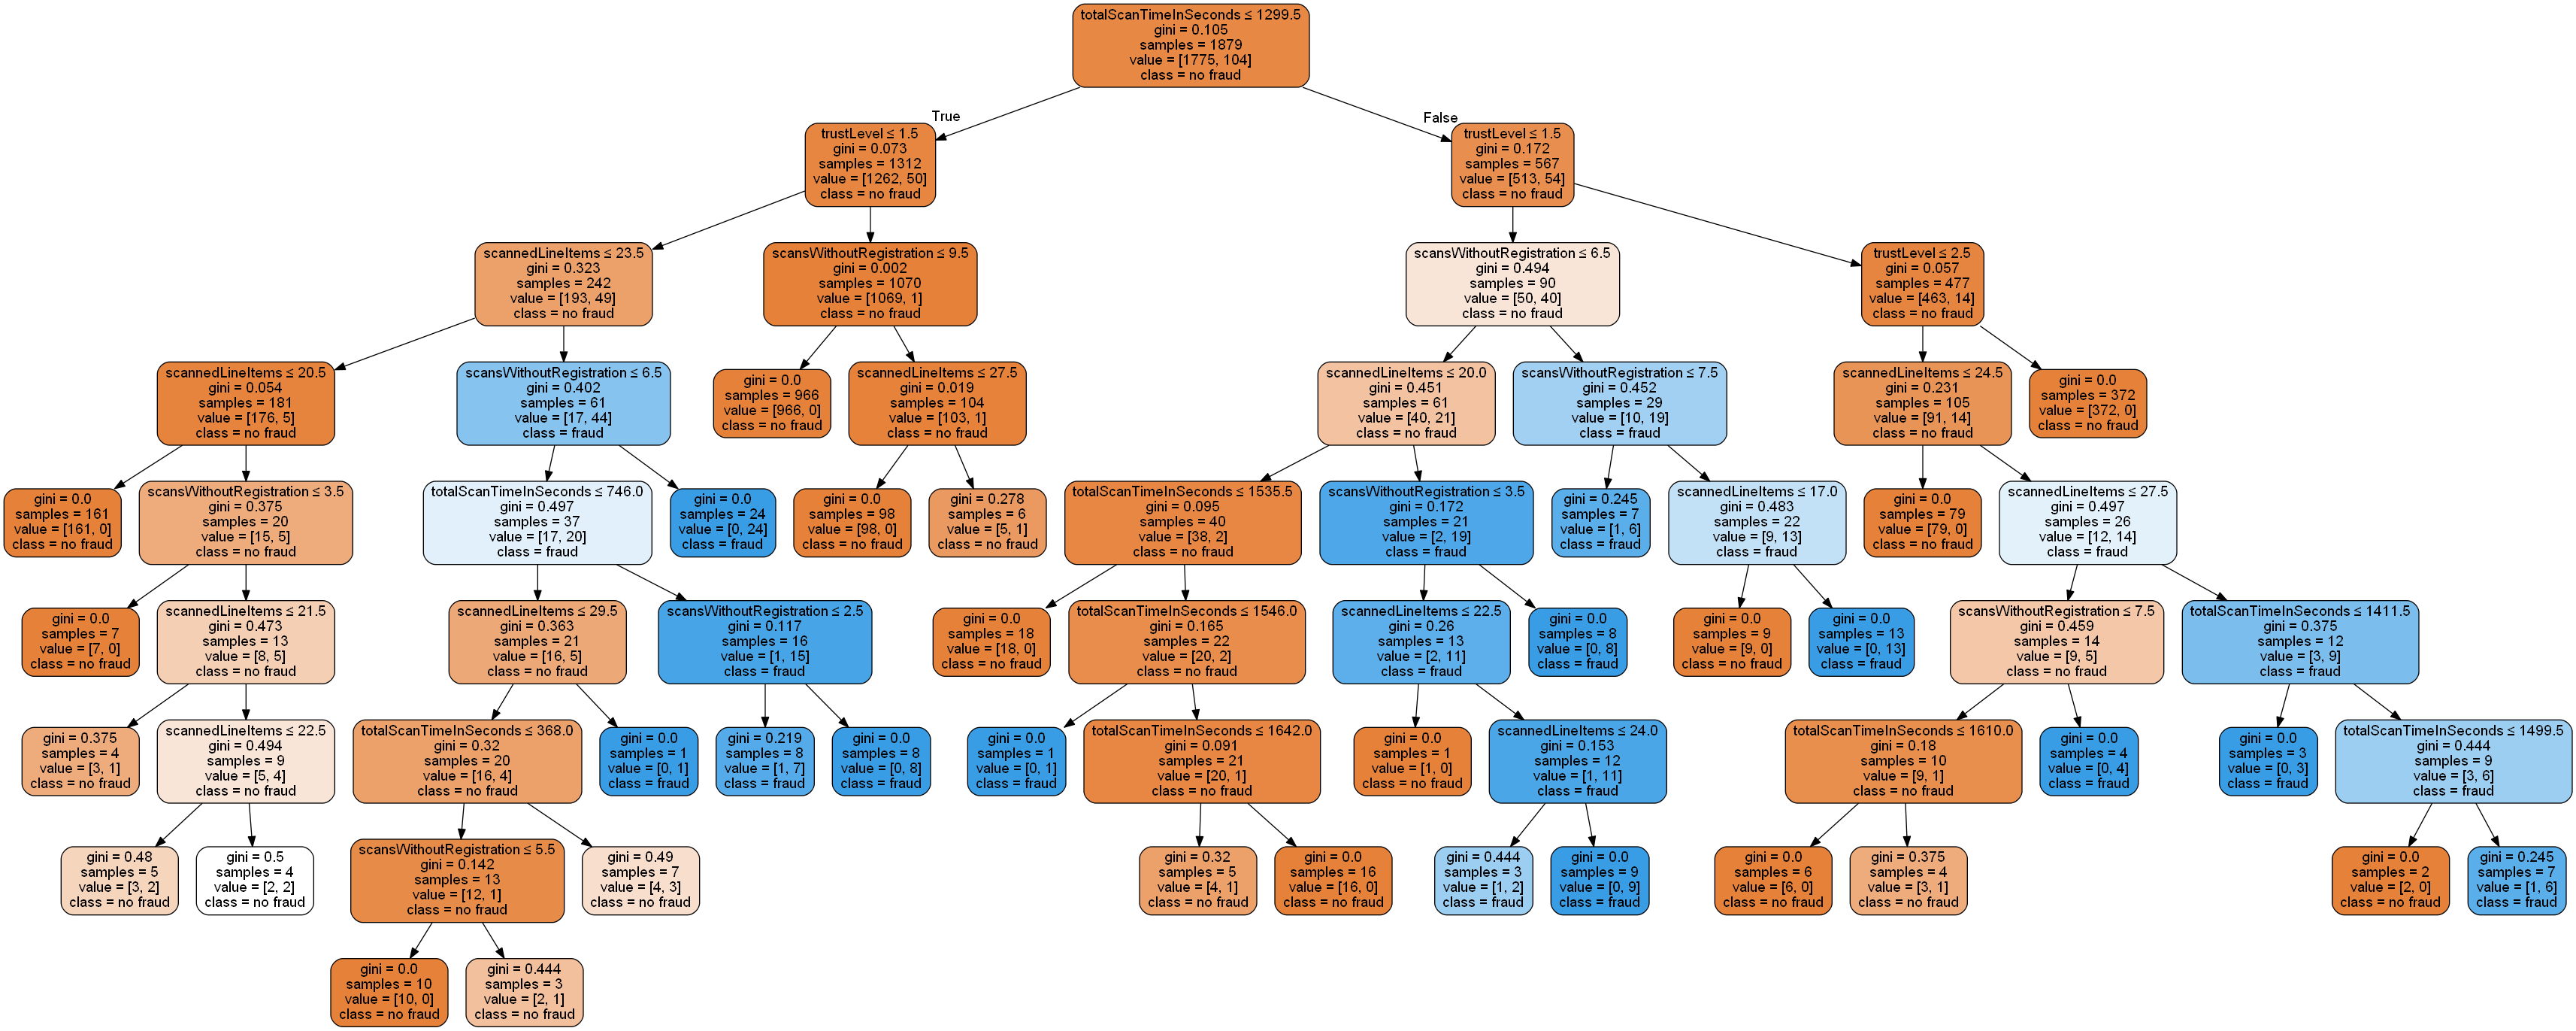

In [20]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

dot_data = StringIO()
export_graphviz(best_model, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, feature_names = best_model_features, class_names=list(['no fraud', 'fraud']))
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

In [21]:
from sklearn.metrics import confusion_matrix

def get_monetary_value(cm):
        tn, fp, fn, tp = cm.ravel()
        print("True negative: ", tn)
        print("False positive: ", fp)
        print("False negative: ", fn)
        print("True positive: ", tp)
        score = (-25)*fp + (-5)*fn + 5*tp
        print(str(score) + " for " + str(sum(sum(cm))) + " instances in the test set")
        print(str(score/sum(sum(cm))) + " per instance in the test set")
        return score
    
cm = confusion_matrix(Y , best_model.predict(X[best_model_features]))

monetary_value = get_monetary_value(cm)

True negative:  1771
False positive:  4
False negative:  12
True positive:  92
300 for 1879 instances in the test set
0.15965939329430548 per instance in the test set
